In [1]:
import os
import sys

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
CNN_EXAMPLE_FILES = os.path.join(CURRENT_DIR, '..', 'examples', 'cnn')
VGG19_WEIGHTS_FILE = os.path.join(CNN_EXAMPLE_FILES, 'files', 'vgg19.pickle')
IMAGE_DIR = os.path.join(CURRENT_DIR, 'images')

sys.path.append(CNN_EXAMPLE_FILES)

### Expected directory structure

In [2]:
os.listdir(IMAGE_DIR)

['beaver',
 'cougar_body',
 'gerenuk',
 'kangaroo',
 'Leopards',
 'llama',
 'okapi',
 'platypus',
 'wild_cat']

In [3]:
beaver_images = os.listdir(os.path.join(IMAGE_DIR, 'beaver'))
beaver_images[:10]

['image_0001.jpg',
 'image_0002.jpg',
 'image_0003.jpg',
 'image_0004.jpg',
 'image_0005.jpg',
 'image_0006.jpg',
 'image_0007.jpg',
 'image_0008.jpg',
 'image_0009.jpg',
 'image_0010.jpg']

### Initializing VGG19 architecture

In [4]:
from imagenet_tools import download_file, load_image, deprocess

In [5]:
import theano
theano.config.floatX = 'float32'

In [6]:
from neupy import layers


vgg19 = layers.join(
    layers.Input((3, 224, 224)),

    layers.Convolution((64, 3, 3), padding=1, name='conv1_1') > layers.Relu(),
    layers.Convolution((64, 3, 3), padding=1, name='conv1_2') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((128, 3, 3), padding=1, name='conv2_1') > layers.Relu(),
    layers.Convolution((128, 3, 3), padding=1, name='conv2_2') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((256, 3, 3), padding=1, name='conv3_1') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_2') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_3') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((512, 3, 3), padding=1, name='conv4_1') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_2') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_3') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((512, 3, 3), padding=1, name='conv5_1') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_2') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_3') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Reshape(name='reshape'),

    layers.Linear(4096, name='dense_1') > layers.Relu(),
    layers.Linear(4096, name='dense_2') > layers.Relu(),
    layers.Linear(1000, name='dense_3') > layers.Softmax(),
)

### Loading pre-trained parameters

In [7]:
import os
from neupy import storage

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url=(
            "http://srv70.putdrive.com/putstorage/DownloadFileHash/"
            "F9A70DEA3A5A4A5QQWE2301487EWQS/vgg19.pickle"
        ),
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights'
    )

storage.load(vgg19, VGG19_WEIGHTS_FILE)

### Loading and pre-processing input images from Caltech-101 dataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

images = []
image_paths = []

for path, directories, image_names in os.walk(IMAGE_DIR):
    for image_name in image_names:
        image_path = os.path.join(path, image_name)
        image = load_image(
            image_path,
            image_size=(224, 224),
            crop_size=(224, 224))
        
        images.append(image)
        image_paths.append(image_path)
        
images = np.concatenate(images, axis=0)
image_paths = np.array(image_paths)
images.shape

(598, 3, 224, 224)

### Propagating images through the network

In [9]:
# slice network is a way that layer with name
# `dense_3` will be  the output layer
# Basically we are excluding layer that applies
# softmax function
dense_3 = vgg19.end('dense_3')

# Compile Theano function that we can use to
# propagate image through the network
dense_3_propagete = dense_3.compile()

dense_3_output = dense_3_propagete(images)
dense_3_output.shape

(598, 1000)

### Initializing and training SOFM on output from VGG19 network

In [10]:
from neupy import algorithms, environment

environment.reproducible()

data = dense_3_output
sofm = algorithms.SOFM(
    n_inputs=data.shape[1],
    
    # Feature map grid is 2 dimensions and has
    # 625 output clusters (25 * 25).
    features_grid=(25, 25),
    
    # Closest neuron (winning neuron) measures
    # using cosine similarity
    distance='euclid',
    
    # Sample weights from the data.
    # Every weight vector will be just a sample
    # from the input data. In this way we can
    # ensure that initialized map will cover data
    # at the very beggining.
    weight='sample_from_data',

    # Defines radius within we consider near by
    # neurons as neighbours relatively to the
    # winning neuron
    learning_radius=6,
    # Large radius is efficient only for the first
    # iterations, that's why we reduce it by 1
    # every 5 epochs.
    reduce_radius_after=5,

    # The further the neighbour neuron from the winning
    # neuron the smaller learning rate for it. How much
    # smaller the learning rate controls by the `std`
    # parameter. The smaller `std` the smaller learning
    # rate for neighboring neurons.
    std=1,
    # Neighbours within 
    reduce_std_after=5,
    
    # Learning rate
    step=0.1,
    # Learning rate is going to be reduced every 5 epochs
    reduce_step_after=5,

    # Shows training progress in terminal
    verbose=True,
)
sofm.train(data, epochs=32)


Main information

[ALGORITHM] SOFM

[OPTION] verbose = True
[OPTION] epoch_end_signal = None
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] step = 0.1
[OPTION] train_end_signal = None
[OPTION] n_inputs = 1000
[OPTION] distance = euclid
[OPTION] features_grid = [25, 25]
[OPTION] grid_type = rect
[OPTION] learning_radius = 6
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 5
[OPTION] reduce_std_after = 5
[OPTION] reduce_step_after = 5
[OPTION] std = 1
[OPTION] weight = sample_from_data


Start training

[TRAINING DATA] shapes: (598, 1000)
[TRAINING] Total epochs: 32

------------------------------------------------
| Epoch # | Train err | Valid err | Time       |
------------------------------------------------
| 1       | 1.494     | -         | 3.8 sec    |
| 2       | 1.327     | -         | 3.2 sec    |
| 3       | 1.317     | -         | 3.3 sec    |
| 4       | 1.317     | -         | 3.2 sec    |
| 5       | 1.265     | -         | 3.6 sec    |
| 6       |

### Visualizing SOFM

In [11]:
from scipy.misc import imread
import matplotlib.gridspec as gridspec

def draw_grid(sofm, images, output_features):
    data = images
    clusters = sofm.predict(output_features).argmax(axis=1)
    grid_height, grid_weight = sofm.features_grid
    
    plt.figure(figsize=(30, 30))

    grid = gridspec.GridSpec(grid_height, grid_weight)
    grid.update(wspace=0, hspace=0)

    for row_id in range(grid_height):
        print("Progress: {:.2%}".format(row_id / grid_weight))

        for col_id in range(grid_weight):
            index = row_id * grid_height + col_id
            clustered_samples = data[clusters == index]

            if len(clustered_samples) > 0:
                # We take the first sample, but it can be any
                # sample from this cluster
                sample = -deprocess(clustered_samples[0])

            else:
                # If we don't have samples in cluster then
                # it means that there is a gap in space
                sample = np.zeros((224, 224, 3))

            plt.subplot(grid[index])
            plt.imshow(sample)
            plt.axis('off')

    print("Progress: 100%")

Progress: 0.00%
Progress: 4.00%
Progress: 8.00%
Progress: 12.00%
Progress: 16.00%
Progress: 20.00%
Progress: 24.00%
Progress: 28.00%
Progress: 32.00%
Progress: 36.00%
Progress: 40.00%
Progress: 44.00%
Progress: 48.00%
Progress: 52.00%
Progress: 56.00%
Progress: 60.00%
Progress: 64.00%
Progress: 68.00%
Progress: 72.00%
Progress: 76.00%
Progress: 80.00%
Progress: 84.00%
Progress: 88.00%
Progress: 92.00%
Progress: 96.00%
Progress: 100%


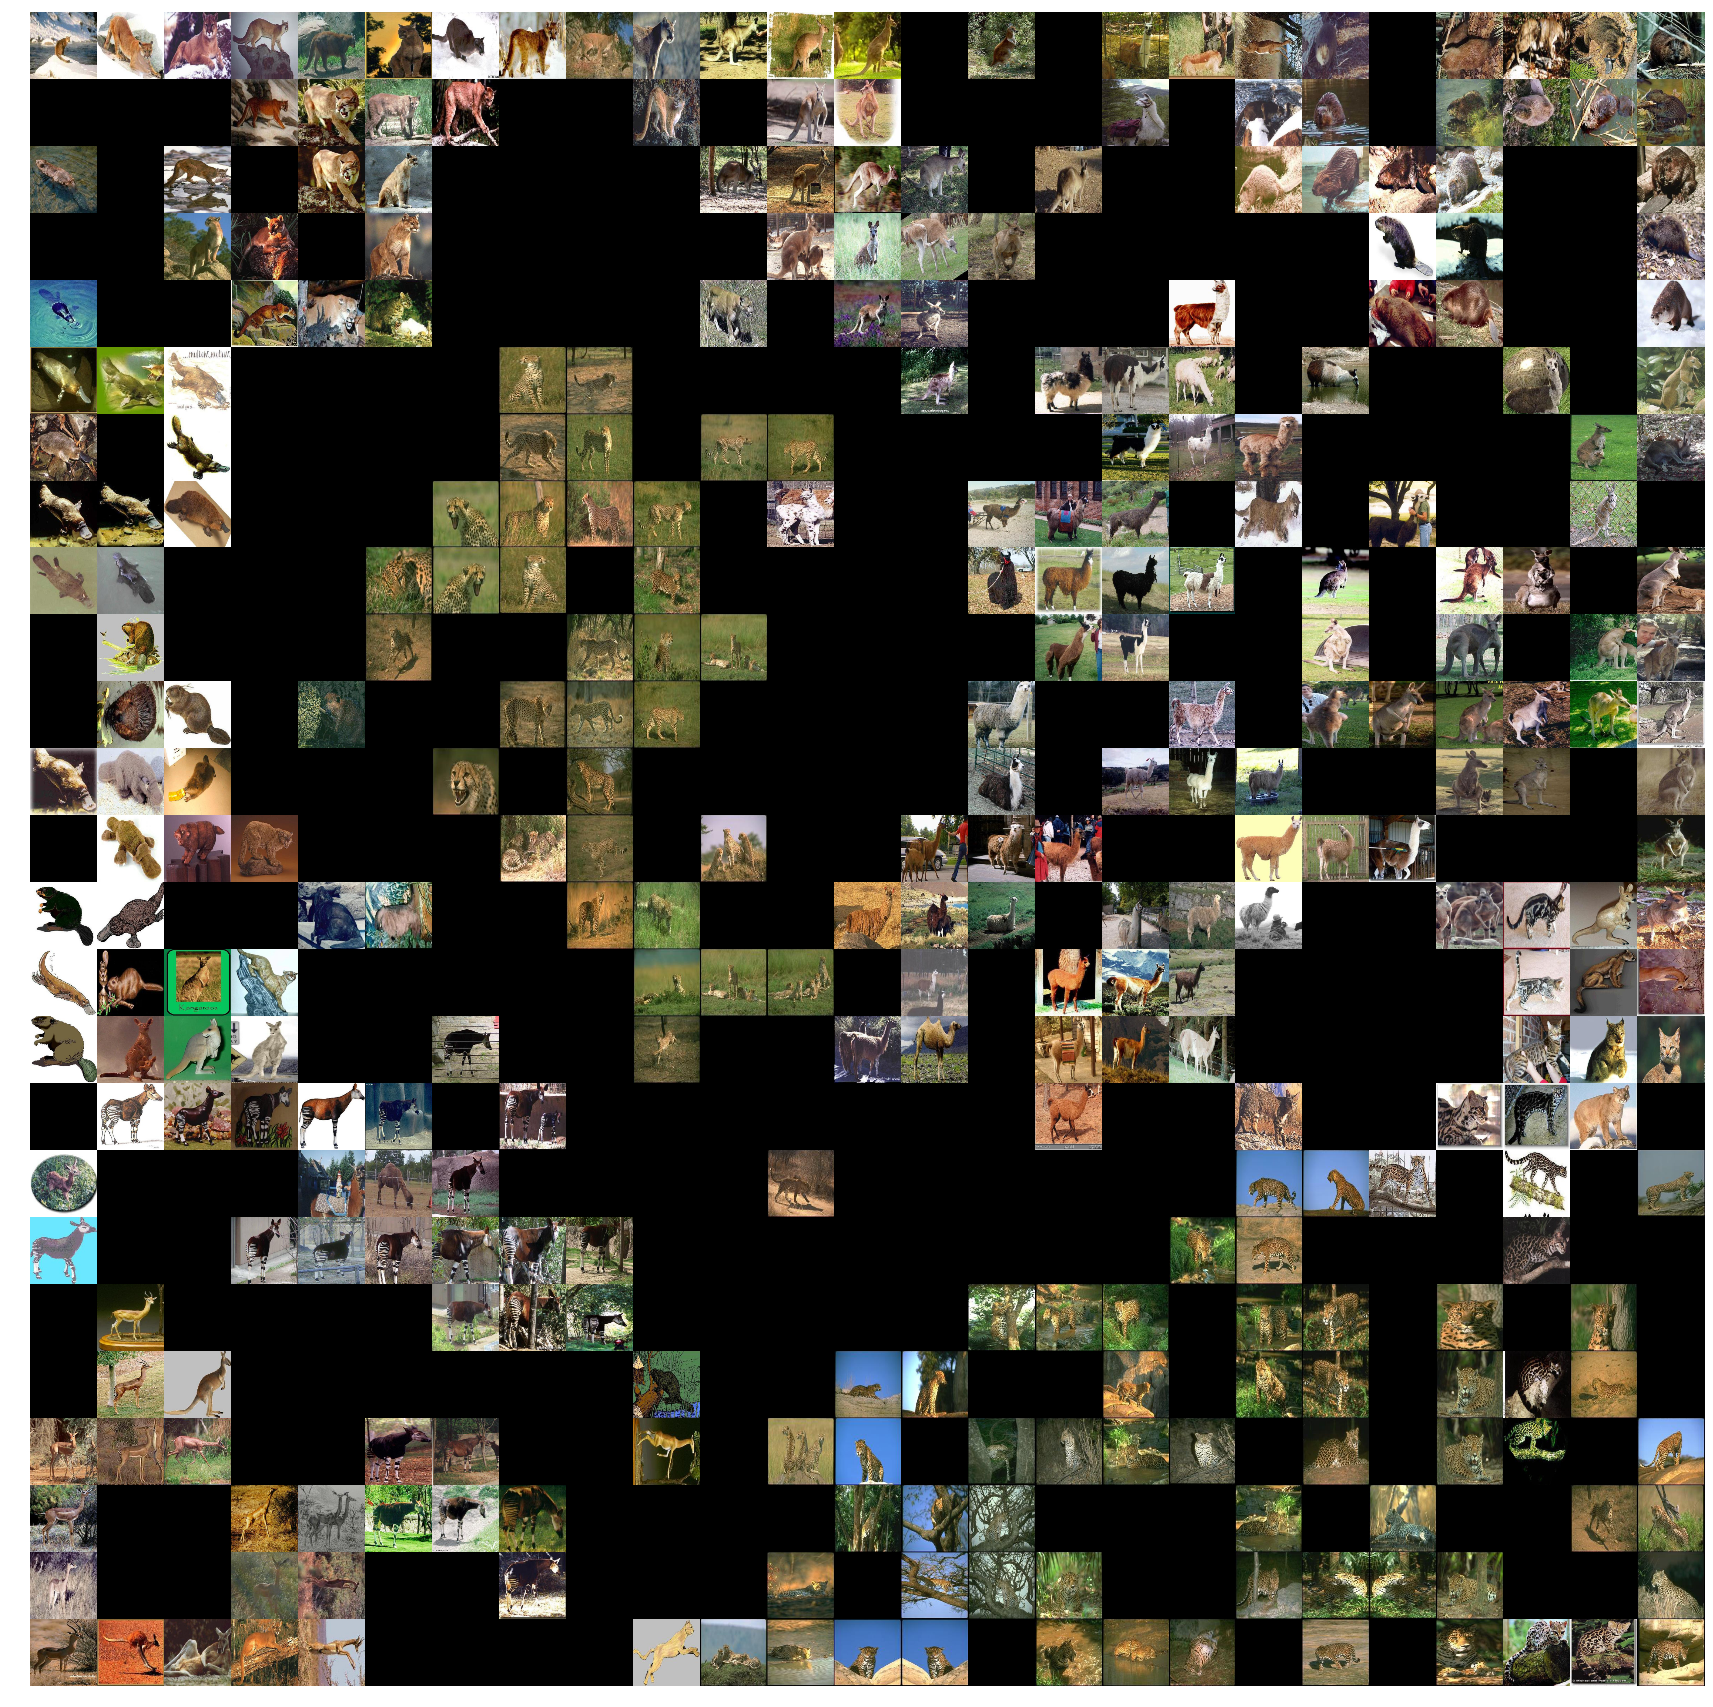

In [12]:
draw_grid(sofm, images, dense_3_output)